## ADA Project Milestone 3: Final Project and Data Story

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time
from datetime import datetime

## Load datasets into pandas Dataframe
- _emdat_public_... is an additional dataset containing the main natural disasters that occured in the world
- _us_disaster_declarations_ is the additional dataset containing all natural disasters in the US from 1953 to 2021. <br>
- _natural_disaster_quotes_ dataset corresponds to the part of the Quotebank dataset that is useful for our project, i.e. it contains quotations citing the incident types. The type of incidents come from the incident_type column in the previous dataset. <br>
Note: We used the provided Google Colab notebook to generate the wanted compressed dataset.

In [2]:
# Load additional datasets

# World dataset : download at https://www.emdat.be/, select 'Natural' and the years from 1960 to 2020 and for all the continents (nd = natural disaters)
nd_world = pd.read_excel('data\emdat_public_2021_12_11_query_uid-ucCmQ2.xlsx', header=6)
nd_world.head(3)

C:\Users\rapha\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Dis No,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damages ('000 US$),"Insured Damages, Adjusted ('000 US$)",Total Damages ('000 US$),"Total Damages, Adjusted ('000 US$)",CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,1960-0013-CHL,1960,13,NaN,Natural,Geophysical,Earthquake,Tsunami,NaN,NaN,...,NaN,NaN,NaN,550000.0,4813056.0,11.427251,NaN,NaN,NaN,NaN
1,1960-0026-AIA,1960,26,NaN,Natural,Meteorological,Storm,Tropical cyclone,NaN,Donna,...,NaN,NaN,NaN,35000.0,306285.0,11.427251,NaN,NaN,NaN,NaN
2,1960-0025-ANT,1960,25,NaN,Natural,Meteorological,Storm,Tropical cyclone,NaN,Donna,...,NaN,NaN,NaN,NaN,NaN,11.427251,NaN,NaN,NaN,NaN


In [3]:
nd_world.columns

Index(['Dis No', 'Year', 'Seq', 'Glide', 'Disaster Group', 'Disaster Subgroup',
       'Disaster Type', 'Disaster Subtype', 'Disaster Subsubtype',
       'Event Name', 'Country', 'ISO', 'Region', 'Continent', 'Location',
       'Origin', 'Associated Dis', 'Associated Dis2', 'OFDA Response',
       'Appeal', 'Declaration', 'Aid Contribution', 'Dis Mag Value',
       'Dis Mag Scale', 'Latitude', 'Longitude', 'Local Time', 'River Basin',
       'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month',
       'End Day', 'Total Deaths', 'No Injured', 'No Affected', 'No Homeless',
       'Total Affected', 'Reconstruction Costs ('000 US$)',
       'Reconstruction Costs, Adjusted ('000 US$)',
       'Insured Damages ('000 US$)', 'Insured Damages, Adjusted ('000 US$)',
       'Total Damages ('000 US$)', 'Total Damages, Adjusted ('000 US$)', 'CPI',
       'Adm Level', 'Admin1 Code', 'Admin2 Code', 'Geo Locations'],
      dtype='object')

In [4]:
# US dataset : download at https://www.kaggle.com/headsortails/us-natural-disaster-declarations
nd_frame = pd.read_csv('data/us_disaster_declarations.csv')
print("Column names and their data types (more info here: \
https://www.kaggle.com/headsortails/us-natural-disaster-declarations )\n")
print(nd_frame.dtypes)

Column names and their data types (more info here: https://www.kaggle.com/headsortails/us-natural-disaster-declarations )

fema_declaration_string       object
disaster_number                int64
state                         object
declaration_type              object
declaration_date              object
fy_declared                    int64
incident_type                 object
declaration_title             object
ih_program_declared            int64
ia_program_declared            int64
pa_program_declared            int64
hm_program_declared            int64
incident_begin_date           object
incident_end_date             object
disaster_closeout_date        object
fips                           int64
place_code                     int64
designated_area               object
declaration_request_number     int64
hash                          object
last_refresh                  object
id                            object
dtype: object


In [5]:
# Not all are "natural" disasters
nd_types = nd_frame.incident_type.unique()
print(nd_types)

['Tornado' 'Flood' 'Fire' 'Other' 'Earthquake' 'Hurricane' 'Volcano'
 'Severe Storm(s)' 'Toxic Substances' 'Typhoon' 'Drought'
 'Dam/Levee Break' 'Snow' 'Severe Ice Storm' 'Freezing' 'Coastal Storm'
 'Fishing Losses' 'Mud/Landslide' 'Human Cause' 'Terrorist' 'Tsunami'
 'Chemical' 'Biological']


This is the dictionary we use to extract relevant quotations from the Quotebank dataset. As we can see, some of them are similar (multiple kinds of storms), and others are not "natural" disasters (Human Cause, Terrorist, ...). Some modifications are done, for instance we must also add lowercase version of the terms, and we will also ignore some types of incidents in further analysis, e.g. Fire, Snow, ..., since they are hard to work with for what we want to accomplish. As we will see, some of these terms are used in other contexts that may be irrelevant. 

In [6]:
# Load quotation dataset

df_quotes = pd.read_json('data/natural_disaster_quotes.json.bz2', lines=True, compression='bz2')
print(f"Number of quotes: %d" % len(df_quotes.index))

Number of quotes: 1480711


In [7]:
# Load 2nd quotation dataset with quotes containing climate/global warming related words (['climate','warming','global','planet','carbon','environment','temperature'])
df_climate = pd.read_json('data/environment-quotes.json.bz2', lines=True, compression='bz2')
print(f"Number of quotes: %d" % len(df_climate.index))

Number of quotes: 1673053


In [8]:
print("Column names and their data types\n")
print(df_quotes.dtypes)

Column names and their data types

quoteID                   object
quotation                 object
speaker                   object
qids                      object
date              datetime64[ns]
numOccurrences             int64
probas                    object
urls                      object
phase                     object
dtype: object


In [9]:
df_quotes.head(3)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2020-01-13-009373,But he said `you're responsible. You make peop...,Tom Elliott,"[Q16196918, Q21461424, Q7815715, Q8952291]",2020-01-13 05:00:53,1,"[[Tom Elliott, 0.5795], [None, 0.4205]]",[https://www.3aw.com.au/tom-elliott-calls-for-...,E
1,2020-03-11-014404,Everything that went wrong was always my fault...,Kate James,[Q56379605],2020-03-11 13:04:58,2,"[[Kate James, 0.8144], [None, 0.1397], [Amber ...",[https://calgarysun.com/entertainment/celebrit...,E
2,2020-04-10-011917,"Great guy, messiest desk I ever saw, like a to...",None,[],2020-04-10 04:00:00,3,"[[None, 0.7283], [Brad Harris, 0.2717]]",[http://newstimes.com/news/coronavirus/article...,E


In [110]:
# Convert the datetime to a simpler format, only keep days (2020-04-26)
df_quotes['date'] = pd.to_datetime(df_quotes['date'].dt.strftime('%Y-%m-%d'))
df_climate['date'] = pd.to_datetime(df_climate['date'].dt.strftime('%Y-%m-%d'))

In [97]:
pd.options.display.max_colwidth = 200 # this is to see most of the text of the quotations
df_quotes.head().quotation
# Lots of irrelevant quotes! 

0                                                                                                                          But he said `you're responsible. You make people think the wrong way about fires.
1    Everything that went wrong was always my fault. I remember one occasion where she missed a connection on a flight on or around Christmas Day in 2012. My aunt was visiting from Australia at that ti...
2    Great guy, messiest desk I ever saw, like a tornado hit a landfill but he knew where everything was! Funniest thing was the time the overnight cleaning crew left a full black garbage bag on his ch...
3        How will they attend to the problems of the people without a full-fledged Ministry? You are not able to provide a Minister in charge of the districts. You are unable to take up flood relief work,
4                                                                                                                           I'm sure you hear it every day but you are smoking hot c

We can see that some terms of crisis can be used in other contexts. For instance, to exagerate a statement or there can be words (e.g. fire) that are used in a lot of fields.

## Data visualization and statistics

Data exploration of the Natural Disaster World dataset

In [12]:
L = list(nd_world.groupby('Disaster Type').groups.keys())
print(f"There are the following disaster categories in the dataset : {L}")
L_keep = ['Drought', 'Earthquake','Extreme temperature ', 'Flood', 'Storm', 'Wildfire']
nd_world = nd_world[nd_world['Disaster Type'].isin(L_keep)]
new_L = list(nd_world.groupby('Disaster Type').groups.keys())
print(f"We are only interested in the following : {new_L}")

There are the following disaster categories in the dataset : ['Animal accident', 'Drought', 'Earthquake', 'Epidemic', 'Extreme temperature ', 'Flood', 'Impact', 'Insect infestation', 'Landslide', 'Mass movement (dry)', 'Storm', 'Volcanic activity', 'Wildfire']
We are only interested in the following : ['Drought', 'Earthquake', 'Extreme temperature ', 'Flood', 'Storm', 'Wildfire']


We see that the number of reported events in the dataset is roughly constant from 2000 on.


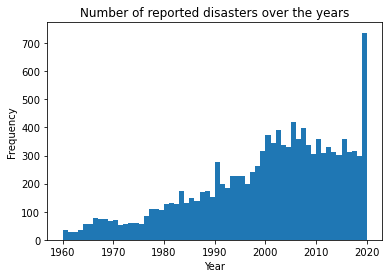

In [13]:
# Number of reported disasters per year
df_year = nd_world.groupby('Year').count()['Dis No']
plt.hist(nd_world['Year'],bins=60)
plt.ylabel('Frequency'); plt.xlabel('Year')
plt.title('Number of reported disasters over the years');
print('We see that the number of reported events in the dataset is roughly constant from 2000 on.')

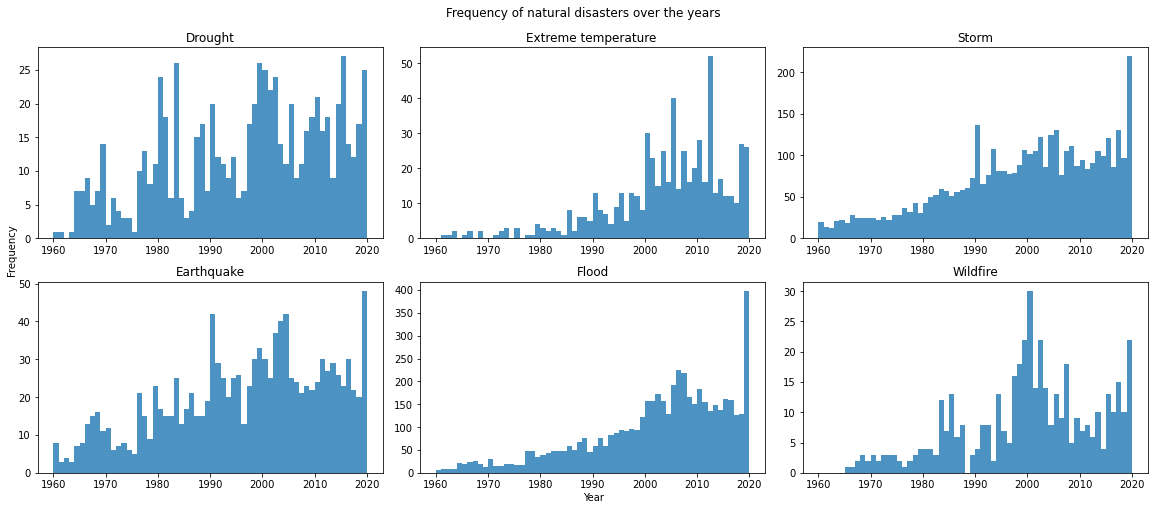

In [14]:
world_by_type = nd_world.copy().groupby('Disaster Type').apply(lambda x: pd.Series({
        'Year': x['Year'].values
    }))

fig, ax = plt.subplots(2, 3, figsize=(16,7), sharey=False, sharex=False)

for i in range(6):
    sbplt = ax[i%2, math.floor(i/2)]
    sbplt.hist(world_by_type.iloc[i].values, range=[1960,2020], bins = 60, alpha = 0.8)
    sbplt.set_title(world_by_type.index[i])

fig.text(0.5,0, "Year")
fig.text(0,0.45, "Frequency", rotation = 90)
fig.suptitle("Frequency of natural disasters over the years")
fig.tight_layout()

In [15]:
world_by_type = nd_world.copy()
# To divide the number of count by the number of quotes of the same year
world_by_type['count'] = world_by_type.apply(lambda x : 1/df_year[x['Year']], axis=1)
world_by_type = world_by_type[['Disaster Type','Year','count']]

world_by_type = world_by_type.groupby(['Disaster Type','Year']).sum()

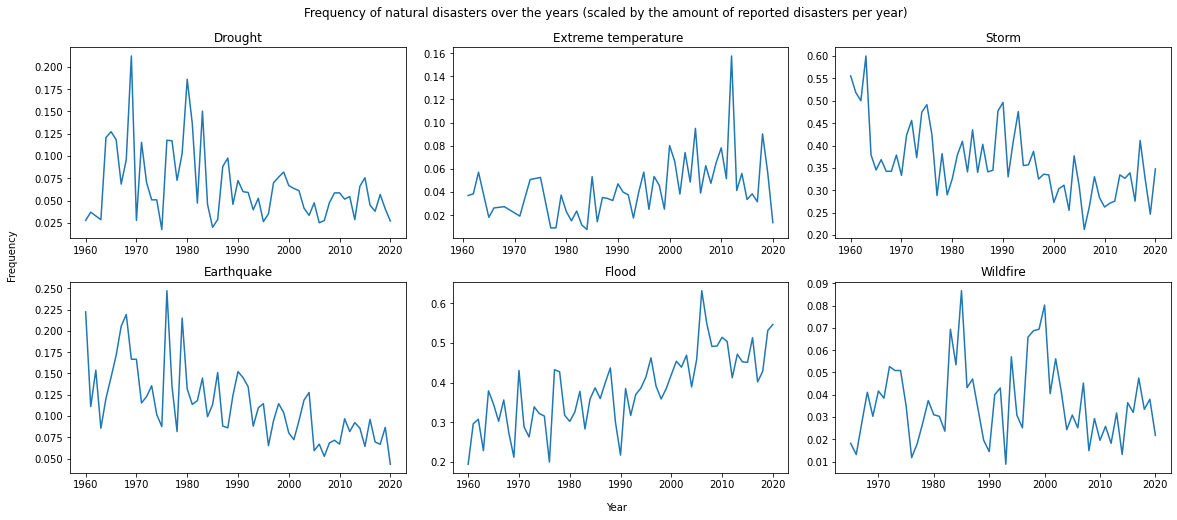

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(16,7), sharey=False, sharex=False)

for i in range(6):
    sbplt = ax[i%2, math.floor(i/2)]
    df_tmp = world_by_type.loc[L_keep[i]]
    sbplt.plot(df_tmp)
    sbplt.set_title(L_keep[i])

fig.text(0.50,-0.02, "Year")
fig.text(-0.02,0.44, "Frequency", rotation = 90)
fig.suptitle("Frequency of natural disasters over the years (scaled by the amount of reported disasters per year)");
fig.tight_layout()

Test : possible to analyse frequency of floods over the years in Philippines, India, Bangladesh (n°1) or Indonesia

232


<AxesSubplot:>

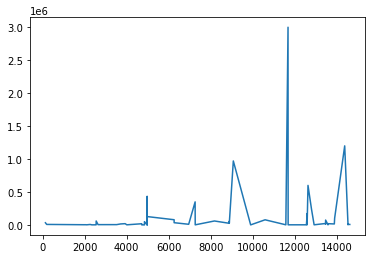

In [17]:
# United States of America (the)
nd_bang = nd_world[nd_world['Country'] == 'Indonesia'].copy()
#nd_bang[['Country','Disaster Type']].head()
nd_bang_flood = nd_bang[nd_bang['Disaster Type']=='Flood']
#nd_bang_flood['Year'].hist(bins=40)
print(len(nd_bang_flood))
nd_bang_flood.dropna(subset=["Total Damages ('000 US$)"])["Total Damages ('000 US$)"].plot()

In [18]:
# Find country with the most floods => India, China, Indonesia
nd_flood = nd_world[nd_world['Disaster Type'] == 'Flood'].copy()
nd_flood = nd_flood.groupby('Country').count().reset_index()
nd_flood.sort_values('Year', ascending=False).head(2)

,Country,Dis No,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damages ('000 US$),"Insured Damages, Adjusted ('000 US$)",Total Damages ('000 US$),"Total Damages, Adjusted ('000 US$)",CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
76,India,291,291,291,18,291,291,291,177,0,...,0,13,13,105,105,291,176,94,110,176
34,China,290,290,290,15,290,290,290,209,0,...,0,19,19,206,206,290,202,127,104,202


Not really increasing


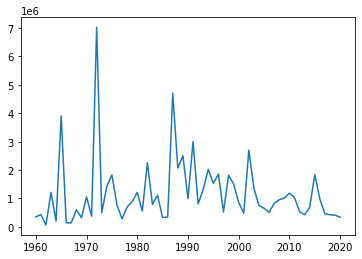

In [19]:
# How many people are affected by natural disasters over the years
nd_affected = nd_world.dropna(subset=['No Affected']).copy()
nd_affected['count'] = 1
#nd_affected.groupby('Year').sum()['No Affected'].plot()
nd_affected = nd_affected.groupby('Year').sum()[['count','No Affected']].reset_index().apply(lambda x : x['No Affected']/x['count'], axis=1)
plt.plot(list(range(1960,2021)),nd_affected.values)
print('Not really increasing')

In [20]:
print(len(nd_world.drop_duplicates(subset=["Total Damages ('000 US$)"])))
print(len(nd_world.drop_duplicates(subset=["Total Damages, Adjusted ('000 US$)"])))
print(len(nd_world.drop_duplicates(subset=["Total Deaths"])))

1512
3683
615


Notable increase in the overal damage caused by natural disasters


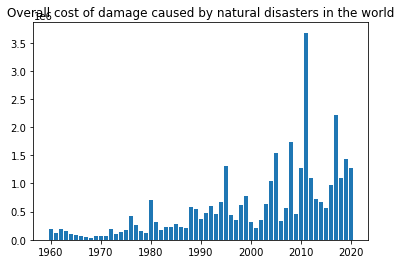

In [21]:
# How much damage caused by natural disasters over the years
classs = "Total Damages ('000 US$)"
nd_damage = nd_world.dropna(subset=[classs]).copy()
nd_damage['count'] = 1
nd_damage = nd_damage.groupby('Year').sum()[['count',classs]].reset_index().apply(lambda x : x[classs]/x['count'], axis=1)
plt.bar(list(range(1960,2021)),nd_damage.values)
plt.title('Overall cost of damage caused by natural disasters in the world')

print("Notable increase in the overal damage caused by natural disasters")

Data exploration of the US natural disaster dataset and of the quotes dataset

Text(0, 0.45, 'Frequency')

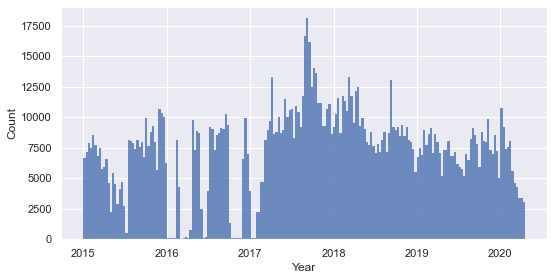

In [80]:
# Add a counter for later
df_quotes['count'] = 1
# Frequency histogram of the quotes w.r.t. dates
sns.set(rc={'figure.figsize':(8.7, 4.27)})
F = sns.histplot(df_quotes['date'], linewidth=0.0, bins=200, alpha=0.8)
F.set(xlabel='Year')

In [23]:
# Extract main peaks of concern in the quotes dataset
df_tmp = df_quotes.copy()
# Count the amount of quotes per day
df_tmp['freq'] = df_tmp.groupby('date')['date'].transform(pd.Series.count)
# Sort them in descending order
df_tmp.sort_values('freq', inplace=True, ascending=False)
# To try to see what natural disaster caused the main peak in 2017-09 => Irma hurricane in first position
df_tmp.drop_duplicates(subset='freq')[['date','urls','freq']].head(1)

,date,urls,freq
963672,2017-09-12,[http://www.islander.org/2017/09/irma-arrives-anna-maria-island-spared-for-most-part/],2636


Text(0, 0.5, 'Frequency')

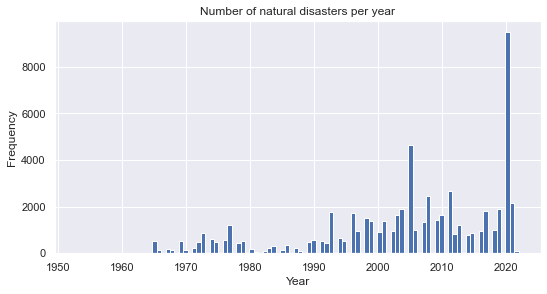

In [24]:
# Natural disasters per year
nd_frame['fy_declared'].hist(bins=100)
plt.title("Number of natural disasters per year")
plt.xlabel("Year")
plt.ylabel("Frequency")

# 2020 because of Covid-19 -> TODO: remove rows after April 2020 (don't have quotes for it) 
# -> Remove "Biological" disasters 

In the graph above, we easily observe that a large number of crisis that happend in 2020. With further investigation of the natural disaster dataset, we see that this mainly represents "Biological" disasters (see following plots), most notably Covid-19. We decided to ignore these types of incident going further, since it is a worldwide pandemic and does not have a fixed time period.

In [25]:
# get data rows from 2015 to 2020 and drop irrelevant rows
nd_frame.drop(nd_frame[nd_frame['fy_declared'] < 2015].index, inplace = True)
nd_frame.drop(nd_frame[nd_frame['fy_declared'] > 2020].index, inplace = True)

nd_frame.drop(nd_frame[nd_frame.incident_type == "Other"].index, inplace = True)
print(nd_frame.head().iloc[:, :7])

      fema_declaration_string  disaster_number state declaration_type  \
44317              DR-4197-NM             4197    NM               DR   
44318              DR-4197-NM             4197    NM               DR   
44319              DR-4197-NM             4197    NM               DR   
44320              DR-4197-NM             4197    NM               DR   
44321              DR-4197-NM             4197    NM               DR   

           declaration_date  fy_declared    incident_type  
44317  2014-10-06T19:20:00Z         2015  Severe Storm(s)  
44318  2014-10-06T19:20:00Z         2015  Severe Storm(s)  
44319  2014-10-06T19:20:00Z         2015  Severe Storm(s)  
44320  2014-10-06T19:20:00Z         2015  Severe Storm(s)  
44321  2014-10-06T19:20:00Z         2015  Severe Storm(s)  


Text(0, 0.5, 'Frequency')

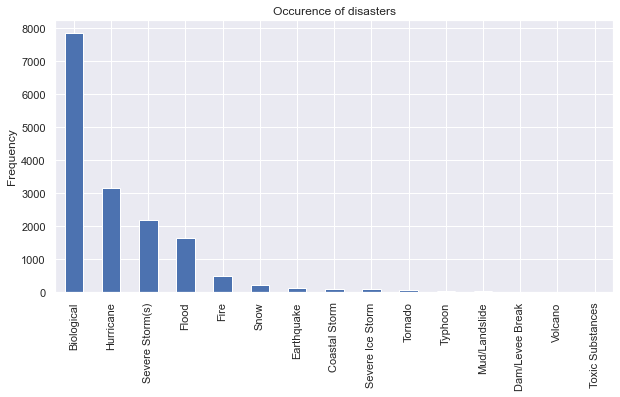

In [26]:
# Occurence of different disasters
nd_frame['incident_type'].value_counts().plot(kind='bar', figsize=(10, 5), title="Occurence of disasters")
plt.ylabel("Frequency")

In [27]:
print(f"Number of natural disasters from 2015 to 2020: %d" % len(nd_frame.index))

Number of natural disasters from 2015 to 2020: 16068


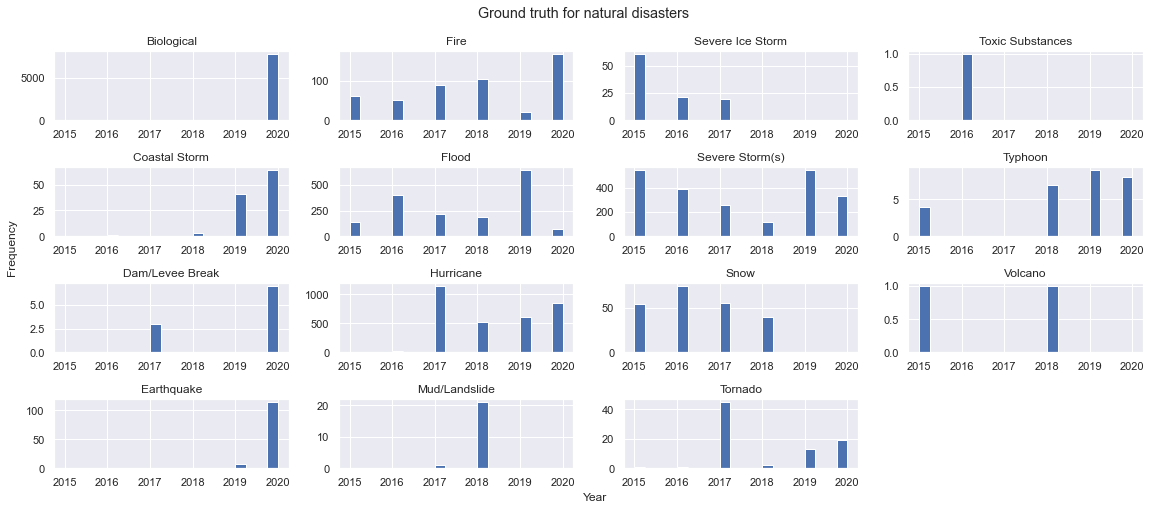

In [28]:
# "Ground truth" plots

stats_by_type = nd_frame.groupby('incident_type').apply(lambda x: pd.Series({
        'fy_declared': x['fy_declared'].values
    }))

fig, ax = plt.subplots(4, 4, figsize=(16,7), sharey=False, sharex=False)

for i in range(15):
    sbplt = ax[i%4, math.floor(i/4)]
    sbplt.hist(stats_by_type.iloc[i].values, range=[2015,2020], bins = 20)
    sbplt.set_title(stats_by_type.index[i])
    
fig.text(0.5,0, "Year")
fig.text(0,0.45, "Frequency", rotation = 90)
fig.delaxes(ax[3][3])
fig.suptitle("Ground truth for natural disasters")
fig.tight_layout()


These are the occurences of the disasters that really happend. As previously said, we see most notably that "Biological" incident happend almost only in 2020. We will now see if it is possible to observe the catastrophies only from the quotations.

In [29]:
# Separate quotes in different dataframes with respect to the type of disaster
def get_occurrence(df, string):
    low_str = string.lower()
    return df[df['quotation'].apply(lambda s: s.lower()).str.contains(low_str)]

df_hurricane = get_occurrence(df_quotes, "hurricane")
df_typhoon = get_occurrence(df_quotes, "typhoon")
df_tornado = get_occurrence(df_quotes, "tornado")
df_flood = get_occurrence(df_quotes, "flood")
# can be more precise, need to explore further
df_storm = get_occurrence(df_quotes, "storm")
df_volcano = get_occurrence(df_quotes, "volcano")
# !!! Fire pretty general term -> discuss that there are a lot of irrelevant quotes
df_fire = get_occurrence(df_quotes, "fire")
df_landslide = get_occurrence(df_quotes, "landslide")
df_earthquake = get_occurrence(df_quotes, "earthquake")
df_dam = get_occurrence(df_quotes, "dam")

In [112]:
df_climate_tmp = df_climate[df_climate['date'] >= '2017']
df_climate_change = get_occurrence(df_climate_tmp, "climate change")
df_carbon = get_occurrence(df_climate_tmp, "carbon")

To have an idea of the trend, we can focus on the years 2017 to 2020. As we saw before with the distribution of the quotes over the years, it is quite inconsistent from 2015 to 2017 with notable gaps and variations in the amount of quotes published every year. It stays quite constant from 2017 on, and it seems like there is an increase in the use of these two words in the media over the years, which could suggest that there's growing concern over the climate change as these two queries are quite specific to the topic of the environment.


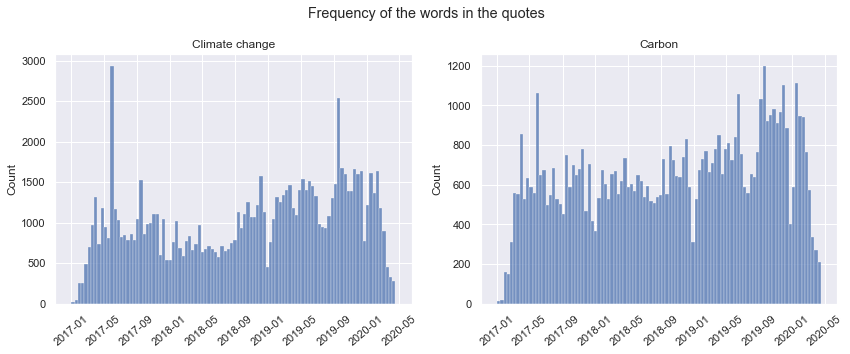

In [122]:
# Plot frequency of each combination of word over time
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Frequency of the words in the quotes')

nb_bins = 100

F1 = sns.histplot(df_climate_change["date"].values, ax=axes[0], bins=nb_bins)
F1.set(title='Climate change')
F2 = sns.histplot(df_carbon["date"].values, ax=axes[1], bins=nb_bins)
F2.set(title='Carbon')

axes[0].tick_params(axis='x', rotation=40)
axes[1].tick_params(axis='x', rotation=40)

fig.tight_layout()

print("To have an idea of the trend, we can focus on the years 2017 to 2020. As we saw before with the distribution of the quotes over the years, it is quite inconsistent from 2015 to 2017 with notable gaps and variations in the amount of quotes published every year. It stays quite constant from 2017 on, and it seems like there is an increase in the use of these two words in the media over the years, which could suggest that there's growing concern over the climate change as these two queries are quite specific to the topic of the environment.")

In [102]:
len(F1.get_xticklabels())

11

In [32]:
# Basic statistics per incident type
print(f"Number of quotes for Hurricanes: %d" % len(df_hurricane.index))
print(f"Number of quotes for Typhoons: %d" % len(df_typhoon.index))
print(f"Number of quotes for Tornados: %d" % len(df_tornado.index))
print(f"Number of quotes for Floods: %d" % len(df_flood.index))
print(f"Number of quotes for Storms: %d" % len(df_storm.index))
print(f"Number of quotes for Volcanos: %d" % len(df_volcano.index))
print(f"Number of quotes for Fires: %d" % len(df_fire.index))
print(f"Number of quotes for Landslides: %d" % len(df_landslide.index))
print(f"Number of quotes for Earthquakes: %d" % len(df_earthquake.index))
print(f"Number of quotes for Dam breaks: %d" % len(df_dam.index))

Number of quotes for Hurricanes: 57043
Number of quotes for Typhoons: 3827
Number of quotes for Tornados: 12096
Number of quotes for Floods: 118441
Number of quotes for Storms: 153573
Number of quotes for Volcanos: 6277
Number of quotes for Fires: 692022
Number of quotes for Landslides: 7748
Number of quotes for Earthquakes: 24523
Number of quotes for Dam breaks: 34599


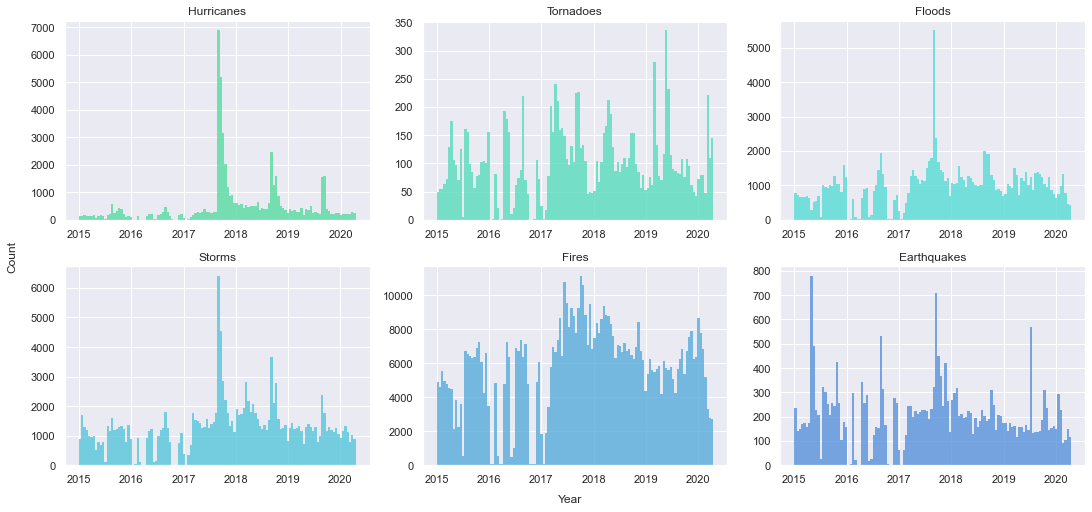

In [96]:
# hurr, tornado, flood, storm, fires, earthquakes

fig, axes = plt.subplots(2, 3, figsize=(15, 7), sharex=False, sharey=False)

i = 25

nb_bins = 120
col = sns.color_palette("hls", 60)
F0 = sns.histplot(x=df_hurricane['date'], bins=nb_bins, ax=axes[0,0], linewidth=0.01, alpha=0.8, color=col[i])
F0.set(xlabel=None, ylabel=None, title='Hurricanes')
F1 = sns.histplot(x=df_tornado['date'], bins=nb_bins, ax=axes[0,1], linewidth=0.01, alpha=0.8, color=col[i+2])
F1.set(xlabel=None, ylabel=None, title='Tornadoes')
F2 = sns.histplot(x=df_flood['date'], bins=nb_bins, ax=axes[0,2], linewidth=0.01, alpha=0.8, color=col[i+4])
F2.set(xlabel=None, ylabel=None, title='Floods')
F3 = sns.histplot(x=df_storm['date'], bins=nb_bins, ax=axes[1,0], linewidth=0.01, alpha=0.8, color=col[i+6])
F3.set(xlabel=None, ylabel=None, title='Storms')
F4 = sns.histplot(x=df_fire['date'], bins=nb_bins, ax=axes[1,1], linewidth=0.01, alpha=0.8, color=col[i+8])
F4.set(xlabel=None, ylabel=None, title='Fires')
F5 = sns.histplot(x=df_earthquake['date'], bins=nb_bins, ax=axes[1,2], linewidth=0.01, alpha=0.8, color=col[i+10])
F5.set(xlabel=None, ylabel=None, title='Earthquakes')


fig.text(0.5,-0.01, "Year")
fig.text(-0.01,0.45, "Count", rotation = 90)
fig.tight_layout()

Closer look on the earthquake data

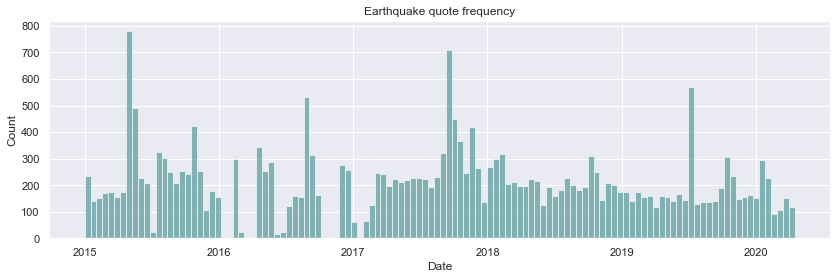

In [372]:
plt.figure(figsize=(14,4))
sns.histplot(x=df_earthquake['date'],bins=120,color='cadetblue')
plt.title("Earthquake quote frequency")
plt.xlabel("Date")
plt.ylabel("Count");

Analysis of the main peaks in quotations for the earthquakes to detect the ones that had the biggest impact in the quotes

In [ ]:
# Earthquake as there are multiple peaks of similar amplitude
df_tmp = df_earthquake.copy()
# Count the amount of quotes per day
df_tmp['freq'] = df_tmp.groupby('date')['date'].transform(pd.Series.count)
# Sort them in descending order
df_tmp.sort_values('freq', inplace=True, ascending=False)

# Retrieve the dates at which the main peaks happen and make it a list to analyse it

# To try to see what natural disaster caused the main peak in 2017-09 => Irma hurricane in first position
earth_peak_dates = df_tmp.drop_duplicates(subset='freq')[['date','freq']].apply(lambda x : [str(x['date'])[:10],x['freq']], axis=1)
print(f"Dates with most occurences of earthquakes in the press [date, count] :\n{earth_peak_dates.head(20)}")

Dates with most occurences of earthquakes in the press [date, count] :
1322811    [2015-04-27, 187]
887548     [2017-09-20, 165]
278567     [2019-07-06, 135]
1329868    [2015-04-28, 134]
1063680    [2016-08-24, 131]
1334882    [2015-04-26, 101]
1264056    [2015-04-25, 100]
772980      [2017-09-19, 80]
726869      [2017-09-21, 78]
1440616     [2015-10-26, 77]
125077      [2019-10-17, 74]
188414      [2019-07-05, 73]
707882      [2017-09-08, 71]
1140965     [2016-08-25, 70]
1148927     [2016-04-19, 68]
879790      [2017-09-23, 65]
994948      [2017-11-21, 62]
1259553     [2015-05-12, 61]
1335598     [2015-04-30, 60]
1041478     [2017-09-28, 58]
dtype: object


From those and looking at the earthquake histogram in the previous section, we confirm that the earthquakes that triggered the biggest reactions in the media are eathquakes from :
- Nepal (April 2015)
- Mexico (September 2017)
- California (July 2019)
- Italy (August 2016)
- Pakistan/Afghanistan (October 2015)
- Philippines (October 2019)
- Mexico (September 2017), 1st of the two that occured in Mexico at that time (1st on the 7th, 2nd on the 19th)

In [389]:
def get_quotes(df, str_list):
    return df[df['quotation'].apply(lambda s: any(word.lower() in s.lower() for word in str_list))]

df_iran = get_quotes(df_earthquake, ['iran','halabja','ezgeleh']) # Words to target the earthquake that occured in Iran
df_italy = get_quotes(df_earthquake, ['accumoli','italy','italia','perugia','aquila','appenines']) # Same with the one in Italy

Dates with most occurences of earthquakes in the press [date, count] :
872906     [2017-11-13, 11]
907172      [2017-11-14, 9]
924172      [2017-11-15, 7]
762947      [2017-11-16, 4]
1026696     [2017-10-09, 3]
349503      [2018-06-27, 2]
1352541     [2015-11-17, 1]
dtype: object


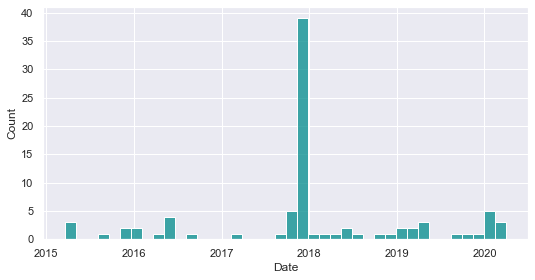

In [390]:
df_tmp = df_iran.copy()

sns.histplot(x=df_tmp['date'],bins=40,color='darkcyan')
plt.xlabel("Date")
plt.ylabel("Count")

df_tmp = df_iran.copy()
# Count the amount of quotes per day
df_tmp['freq'] = df_tmp.groupby('date')['date'].transform(pd.Series.count)
# Sort them in descending order
df_tmp.sort_values('freq', inplace=True, ascending=False)

# Retrieve the dates at which the main peaks happen and make it a list to analyse it

# To try to see what natural disaster caused the main peaks
peak_dates = df_tmp.drop_duplicates(subset='freq')[['date','freq']].apply(lambda x : [str(x['date'])[:10],x['freq']], axis=1)
print(f"Dates with most occurences of earthquakes in the press [date, count] :\n{peak_dates.head(20)}")

Dates with most occurences of earthquakes in the press [date, count] :
1150091    [2016-08-24, 50]
1141256    [2016-08-25, 22]
1114029    [2016-08-26, 12]
1163300     [2016-08-27, 4]
1068369     [2016-09-01, 3]
1161055     [2016-05-31, 2]
465516      [2018-03-05, 1]
dtype: object


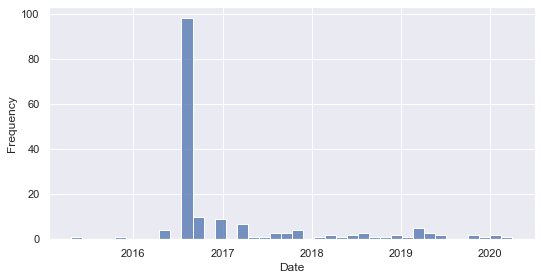

In [396]:
df_tmp = df_italy.copy()

sns.histplot(x=df_tmp['date'],bins=40)
plt.xlabel("Date")
plt.ylabel("Frequency")


df_tmp = df_italy.copy()
# Count the amount of quotes per day
df_tmp['freq'] = df_tmp.groupby('date')['date'].transform(pd.Series.count)
# Sort them in descending order
df_tmp.sort_values('freq', inplace=True, ascending=False)

# Retrieve the dates at which the main peaks happen and make it a list to analyse it

# To try to see what natural disaster caused the main peaks
peak_dates = df_tmp.drop_duplicates(subset='freq')[['date','freq']].apply(lambda x : [str(x['date'])[:10],x['freq']], axis=1)
print(f"Dates with most occurences of earthquakes in the press [date, count] :\n{peak_dates.head(20)}")

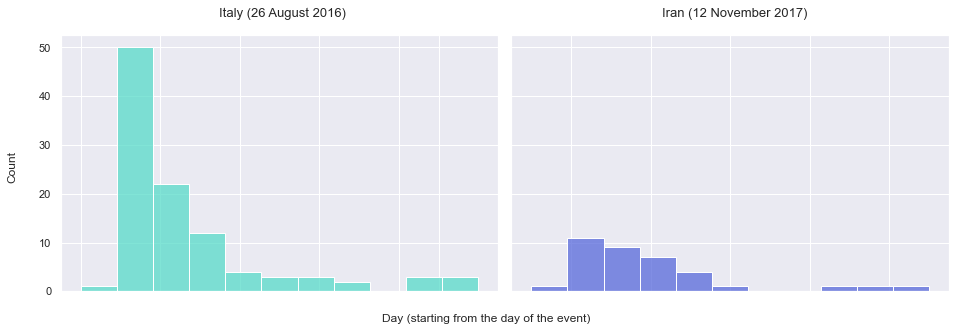

In [392]:
# Plot the 11-days window of time around the occurence of the earthquake of the two main earthquakes (Iran and Italy)

fig_e, ax_e = plt.subplots(1,2,figsize=(13,4),sharex=False,sharey=True)

df_it_tmp = df_italy.copy()[(df_italy['date'] > '2016-08') & (df_italy['date'] <= '2016-09-02')]
df_ir_tmp = df_iran.copy()[(df_iran['date'] > '2017-11') & (df_iran['date'] <= '2017-11-22')]
nb_bins = 11

col = sns.color_palette("hls", 60)

F0 = sns.histplot(x=df_it_tmp['date'], ax=ax_e[0], bins=nb_bins, color=col[28])
F0.set(xlabel=None, ylabel=None, xticklabels=[])
F1 = sns.histplot(x=df_ir_tmp['date'], ax=ax_e[1], bins=nb_bins, color=col[38])
F1.set(xlabel=None, ylabel=None, xticklabels=[])

ax.set_title('Title', pad=20)
fig_e.text(0.206, 1.02, 'Italy (26 August 2016)', fontsize=13)
fig_e.text(0.68, 1.02, 'Iran (12 November 2017)', fontsize=13)
fig_e.text(0.38, -0.04, "Day (starting from the day of the event)")
fig_e.text(-0.02, 0.45, "Count", rotation = 90)
fig_e.tight_layout()

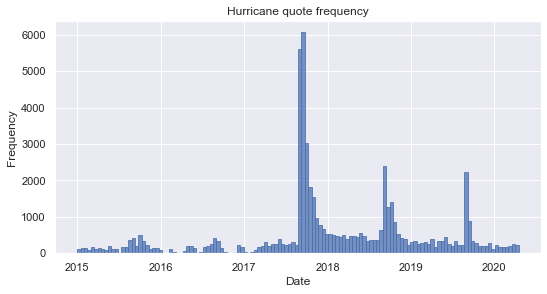

In [388]:
# Plots w.r.t. dates
sns.histplot(x=df_hurricane['date'],bins=130, edgecolor='b', linewidth=0.8)
plt.title("Hurricane quote frequency")
plt.xlabel("Date")
plt.ylabel("Frequency");
# Need to see correlation with ground truth

We see that the big spike in late 2017 corresponds to the larger-than-usual hurricane season that occurred that year.
We can also see the seasonal trend during hurricane season. surprisingly it only starts in 2017.

Text(0, 0.5, 'Frequency')

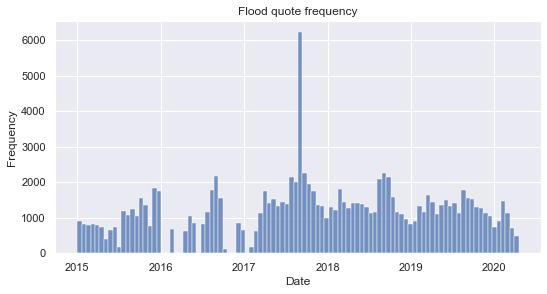

In [46]:
sns.histplot(x=df_flood['date'],bins=100)
plt.title("Flood quote frequency")
plt.xlabel("Date")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

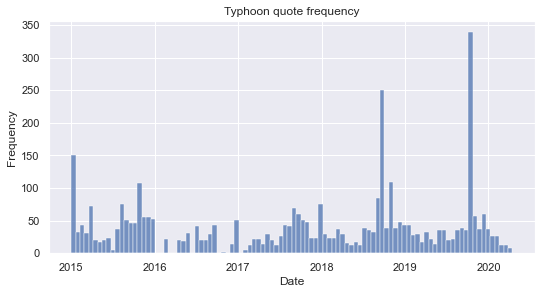

In [362]:
sns.histplot(x=df_typhoon['date'], bins=100)
plt.title("Typhoon quote frequency")
plt.xlabel("Date")
plt.ylabel("Frequency")

## Example: Hurricanes and Florida

For example purposes, we perform a quick analysis among the quotes that contain
the word "hurricane". We would like to see if we can locate in time and space
the occurrence of notable hurricanes.

In [397]:
# This is a list of all states and their capital
# We may use a more refined list of locations in the future
places = np.array(["Montgomery", "Alabama", "Juneau", "Alaska", "Phoenix", "Arizona", "Little Rock", "Arkansas",
                  "Sacramento", "California", "Denver", "Colorado", "Hartford", "Connecticut", "Dover", "Delaware",
                  "Tallahassee", "Florida", "Atlanta", "Georgia", "Honolulu", "Hawaii", "Boise", "Idaho",
                  "Springfield", "Illinois", "Indianapolis", "Indiana", "Des Moines", "Iowa", "Topeka", "Kansas",
                  "Frankfort", "Kentucky", "Baton Rouge", "Louisiana", "Augusta", "Maine", "Annapolis", "Maryland", 
                  "Boston", "Massachusetts", "Lansing", "Michigan", "St. Paul", "Minnesota", "Jackson", "Mississippi",
                  "Jefferson City", "Missouri", "Helena", "Montana", "Lincoln", "Nebraska", "Carson City", "Nevada",
                  "Concord", "New Hampshire", "Trenton", "New Jersey", "Santa Fe", "New Mexico",
                  "Albany", "New York", "Raleigh", "North Carolina", "Bismarck", "North Dakota", "Columbus", "Ohio",
                  "Oklahoma City", "Oklahoma", "Salem", "Oregon", "Harrisburg", "Pennsylvania", "Providence", "Rhode Island", 
                  "Columbia", "South Carolina", "Pierre", "South Dakota", "Nashville", "Tennessee", "Austin", "Texas", 
                  "Salt Lake City", "Utah", "Montpelier", "Vermont", "Richmond", "Virginia", "Olympia", "Washington",
                  "Charleston", "West Virginia", "Madison", "Wisconsin", "Cheyenne", "Wyoming"])
print(len(places))
pattern = '|'.join(places)
#print(pattern)

100


In [398]:
df_loc = df_hurricane[df_hurricane['quotation'].str.contains(pattern)]

In [399]:
df_loc.head().quotation

517                 It's like we have 54 separate hurricanes in every state and territory and the District of Columbia... Unlike a hurricane, we don't know when this is going to dissipate or move out to sea,
2038                  I thank FEMA for their continued commitment to our Florida communities in their recovery from Hurricane Irma. The reimbursement announced last night for St. John's County is great news,
2747                                             We did a study a few years ago that showed Hurricane Harvey in Texas passed over a very warm body of water, and that greatly increased the amount of rainfall.
2793                                          Every hurricane season, we have lots of questions come in and in the event that something does happen in Central Florida, we're able to update that in real-time,
3044    Backstory: During Hurricane Harvey, the MuttNation Team went to Houston to help relocate existing shelter dogs to free up shelter space for animals separated by

In [400]:
print(f"Number of quotations containing hurricane + state/city: %d" % len(df_loc.index))

Number of quotations containing hurricane + state/city: 9036


In [401]:
place_occurrence = [len(df_hurricane[df_hurricane["quotation"].str.contains(place)].index) for place in places]

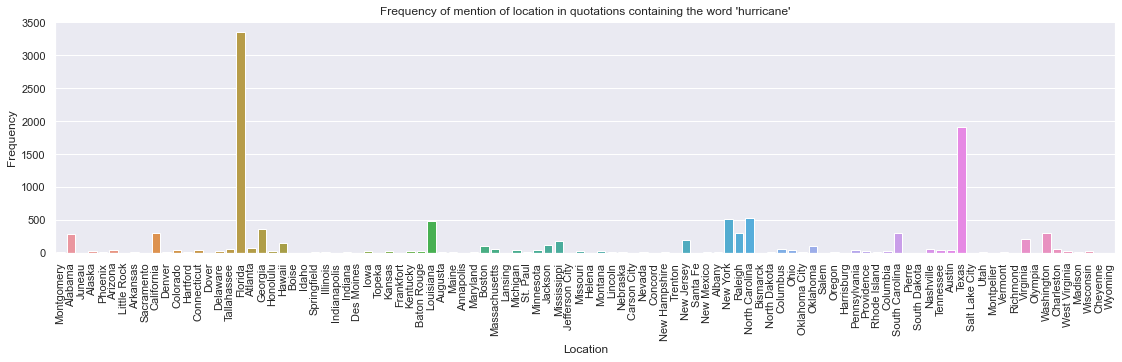

In [409]:
sns.set(rc={'figure.figsize':(19,4.27)})

B = sns.barplot(x=places, y=place_occurrence)
B.set_xticklabels(B.get_xticklabels(), rotation=90)
#axes[0].tick_params(axis='x', rotation=90)
#axes[1].tick_params(axis='x', rotation=90)

plt.xlabel("Location")
plt.ylabel("Frequency")
plt.title("Frequency of mention of location in quotations containing the word 'hurricane'");

Unsurprisingly, quotes that talk about hurricanes also frequently mention
Florida. In the future, we should compute the same graph also accounting for the
population size.

Text(0, 0.5, 'Frequency')

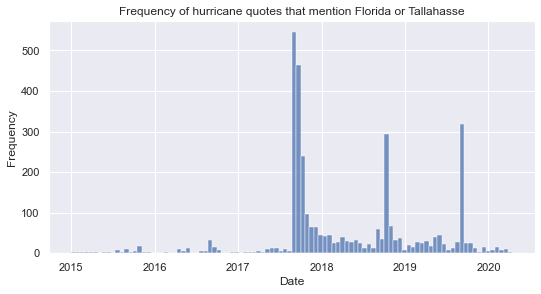

In [414]:
time_loc = get_occurrence(df_hurricane, "florida|tallahasse")["date"].value_counts().sort_index()
sns.set(rc={'figure.figsize':(8.7, 4.27)})
sns.histplot(x=get_occurrence(df_hurricane, "florida|tallahasse")['date'],bins=100)
plt.title("Frequency of hurricane quotes that mention Florida or Tallahasse")
plt.xlabel("Date")
plt.ylabel("Frequency")

## 2nd Example : Detecting the location of a Wildfire

We show for a specific example that it seems possible to infer the location of a major natural disaster (quotation-wise) from both datasets.

In [86]:
df_wildfire = get_occurrence(df_quotes, "wildfire")

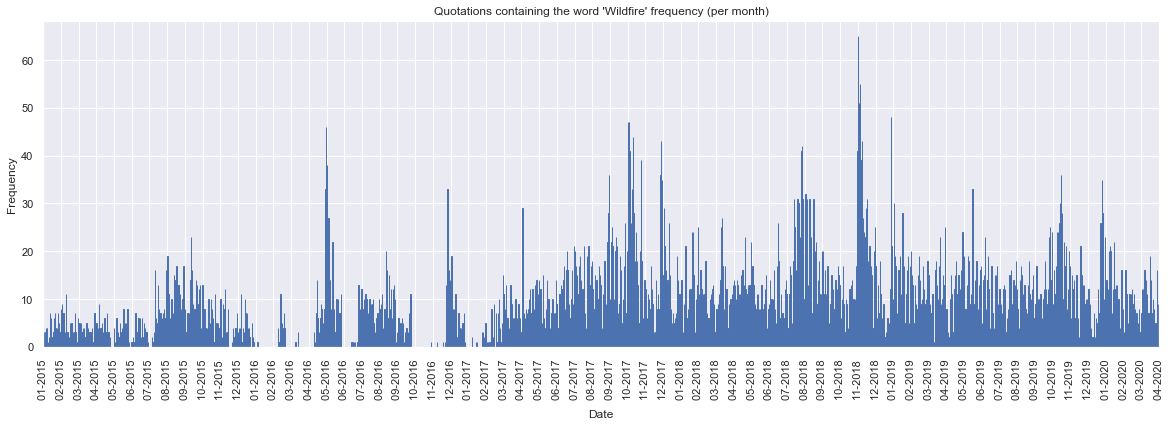

In [98]:
df_wildfire_month = df_wildfire.groupby(pd.Grouper(key='date', axis=0, freq='M')).sum()
df_wildfire_day = df_wildfire.groupby(pd.Grouper(key='date', axis=0, freq='D')).sum()

plt.figure(figsize=(20,6))
df_wildfire_day['count'].plot(kind='bar',edgecolor='b')
plt.xticks(np.linspace(0,len(df_wildfire_day['count']),len(df_wildfire_month['count'])),df_wildfire_month['count'].index.strftime("  %m-%Y ").tolist())
plt.title("Quotations containing the word 'Wildfire' frequency (per month)")
plt.xlabel("Date")
plt.ylabel("Frequency");

As an example, we can take the main peak in quotation frequency containing the word 'Wildfire', and try to extract the location of that wildfire.

In [29]:
# Retrieve the date at which the main frequency peak occured
WF_date = df_wildfire_day['count'].idxmax()
print(f"Date at which the main frequency peak occured : {WF_date}")

# Retrieve the approriate rows from the natural disaster dataframe
nd_wildfire = nd_frame[(nd_frame['incident_type']=='Fire') & (nd_frame['declaration_title']=='Wildfires')]

nd_wildfire = nd_wildfire.dropna(subset=['incident_begin_date', 'incident_end_date'])

# Convert the date columns from str to datetime
nd_wildfire['incident_begin_date'] = pd.to_datetime(nd_wildfire['incident_begin_date'])
nd_wildfire['incident_begin_date'] = nd_wildfire['incident_begin_date'].apply(lambda p : p.tz_localize(None))
nd_wildfire['incident_end_date'] = pd.to_datetime(nd_wildfire['incident_end_date'])
nd_wildfire['incident_end_date'] = nd_wildfire['incident_end_date'].apply(lambda p : p.tz_localize(None))

# Only keep the rows with WF_date in [incident_begin_date, incident_end_date]
nd_keep = nd_wildfire[(nd_wildfire['incident_begin_date'] <= WF_date) & (nd_wildfire['incident_end_date'] >= WF_date)]
nd_keep.head()

Date at which the main frequency peak occured : 2018-11-13 00:00:00


,fema_declaration_string,disaster_number,state,declaration_type,declaration_date,fy_declared,incident_type,declaration_title,ih_program_declared,ia_program_declared,...,incident_begin_date,incident_end_date,disaster_closeout_date,fips,place_code,designated_area,declaration_request_number,hash,last_refresh,id
49324,EM-3409-CA,3409,CA,EM,2018-11-09T16:50:00Z,2019,Fire,Wildfires,0,0,...,2018-11-08,2018-11-25 23:59:00,NaN,6037,99037,Los Angeles (County),18126,0fa08ab30fcf9d7155f0caf1da4945bf993c7245,2021-07-13T23:02:04Z,60c3b85ca0ee349d710a79af
49325,EM-3409-CA,3409,CA,EM,2018-11-09T16:50:00Z,2019,Fire,Wildfires,0,0,...,2018-11-08,2018-11-25 23:59:00,NaN,6111,99111,Ventura (County),18126,ae1e2bb6f0447384b06fd31ae7a0d5c1e1a882c8,2021-07-13T23:02:04Z,60c3b85ca0ee349d710a79b2
49326,EM-3409-CA,3409,CA,EM,2018-11-09T16:50:00Z,2019,Fire,Wildfires,0,0,...,2018-11-08,2018-11-25 23:59:00,NaN,6007,99007,Butte (County),18126,235966a3eb4704d960dc161d925a0f4cc3ea1d56,2021-07-13T23:02:04Z,60c3b85ca0ee349d710a79aa
49327,DR-4407-CA,4407,CA,DR,2018-11-12T20:28:00Z,2019,Fire,Wildfires,1,0,...,2018-11-08,2018-11-25 23:59:00,NaN,6111,99111,Ventura (County),18127,3f221e0f56229a361a105b9526737aaded31dc19,2021-07-13T23:02:16Z,60c3b869a0ee349d710b66c3
49328,DR-4407-CA,4407,CA,DR,2018-11-12T20:28:00Z,2019,Fire,Wildfires,1,0,...,2018-11-08,2018-11-25 23:59:00,NaN,6007,99007,Butte (County),18127,5c84c04921040155f08bde14739d02497dd41039,2021-07-13T23:02:16Z,60c3b869a0ee349d710b66ad


In [30]:
location = nd_keep['state'].value_counts().idxmax()
print(f"Most probable state location of the wildfires that caused the peak (on {WF_date}) : {location[:10]} (California), \n\
which coincides with the massive wildfires that indeed took place in November 2018. We therefore see that by targetting a \n\
peak of concern in the quotation dataset, we can extract the most probable location of the natural event, and we could \n\
imagine building a map of the US reconstructing that information in space from the quotes.")

Most probable state location of the wildfires that caused the peak (on 2018-11-13 00:00:00) : CA (California), 
which coincides with the massive wildfires that indeed took place in November 2018. We therefore see that by targetting a 
peak of concern in the quotation dataset, we can extract the most probable location of the natural event, and we could 
imagine building a map of the US reconstructing that information in space from the quotes.


## Last part : correlations between speakers and natural disasterrs

In [31]:
# Count if there are some speakers that occur more often
speaker_count = df_quotes["speaker"].value_counts()
speaker_count.head(10)

None                      514208
President Donald Trump      6458
Donald Trump                3558
Narendra Modi               3007
President Trump             2921
Benjamin Netanyahu          2253
Recep Tayyip Erdogan        2026
Vladimir Putin              2011
President Barack Obama      1836
Hillary Clinton             1477
Name: speaker, dtype: int64

In [32]:
speaker_count = df_loc["speaker"].value_counts()
speaker_count.head(10)

None                      3042
Gov. Rick Scott            205
President Donald Trump     130
Roy Cooper                 121
Greg Abbott                115
Ron DeSantis                80
Governor Rick Scott         77
Marco Rubio                 69
Henry McMaster              63
President Trump             62
Name: speaker, dtype: int64

If we look at the speakers over all quotes we find that the most frequently
occurring ones are national presidents. While if we restrict ourselves to quotes
that mention notable places in the USA, the speakers are mostly american
politicians. Regardless it is surprising that we do not see any "influential"
person that is not a politician.

Also we note that for most quotes we are not sure of who is the speaker.